# Performance comparison

This notebook compares the performance of `cuDF` and `pandas`. The comparisons performed are on identical data sizes. This notebook primarily showcases the factor
of speedups users can have when the similar `pandas` APIs are run on GPUs using `cudf`.

The hardware details used to run these performance comparisons are at the end of this page.

**Note**: This notebook is written to measure performance on NVIDIA GPUs with large memory. If running on hardware with lower memory, please consider lowering the `num_rows` values. Performance results may vary by data size, as well as the CPU and GPU used.

In [1]:
import timeit

import cudf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(f"{cudf.__version__=}")

cudf.__version__='24.04.00'


In [2]:
rng = np.random.default_rng(seed=0)

## Concat, count & joins performance

In [3]:
timeit_number = 30
num_rows = 300_000_000
sub_sample = int(num_rows / 30)

In [4]:
pdf = pd.DataFrame(
    {
        "numbers": rng.integers(-1000, 1000, num_rows, dtype="int64"),
        "business": rng.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [5]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [6]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [7]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=timeit_number
)

In [8]:
pdf = pdf.head(sub_sample)
gdf = gdf.head(sub_sample)

In [9]:
pandas_concat = timeit.timeit(
    lambda: pd.concat([pdf, pdf, pdf]), number=timeit_number
)

In [10]:
cudf_concat = timeit.timeit(
    lambda: cudf.concat([gdf, gdf, gdf]), number=timeit_number
)

In [11]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=timeit_number,
)

In [16]:
pdf = pd.DataFrame(
    {
        "numbers": rng.integers(
            -1000, 1000, int(sub_sample / 10), dtype="int64"
        ),
        "business": rng.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=int(sub_sample / 10)
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [17]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=10
)

In [18]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)
performance_df

,cudf speedup vs. pandas
value_counts,168.465151
concat,29.828922
groupby,46.671713
merge,45.633230


In [19]:
def performance_plot(df, xlabel=None):
    # ylim is 20% above max value
    ylim_max = df["cudf speedup vs. pandas"].max() + (
        df["cudf speedup vs. pandas"].max() / 20
    )
    ax = df.plot.bar(
        color="#7400ff",
        ylim=(1, ylim_max),
        rot=0,
        xlabel=xlabel,
        ylabel="Speedup factor",
    )
    ax.bar_label(ax.containers[0], fmt="%.0f")
    plt.show()

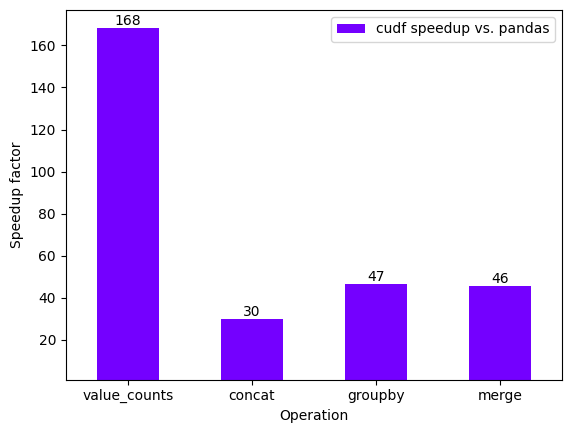

In [20]:
performance_plot(performance_df, xlabel="Operation")

In [21]:
import gc

# Cleaning up used memory for later benchmarks
del pdf
del gdf

_ = gc.collect()

## Strings Performance

In [11]:
timeit_number = 20
num_rows = 300_000_000

In [12]:
pd_series = pd.Series(
    rng.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=num_rows
    )
)

In [13]:
gd_series = cudf.from_pandas(pd_series)

In [14]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=timeit_number
)

In [15]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series,
    gd_series,
    lambda s: s.str.contains(r"[0-9][a-z]"),
    number=timeit_number,
)

In [16]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=timeit_number
)

In [17]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)
performance_df

,cudf speedup vs. pandas
upper,376.502445
contains,405.030084
isalpha,1974.166058


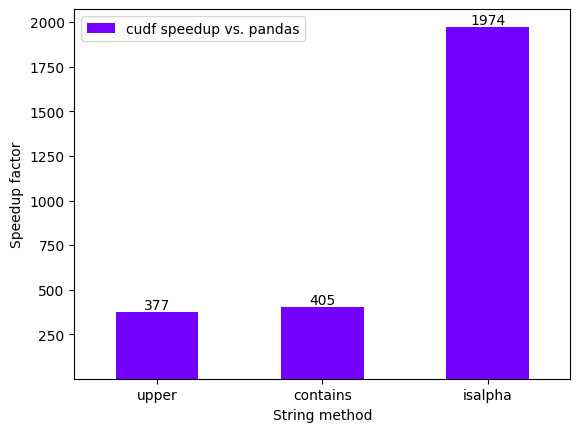

In [18]:
performance_plot(performance_df, xlabel="String method")

## User-defined function (UDF) performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of first run and average of next few runs are compared separately.

In [19]:
num_rows = 10_000_000

In [20]:
pdf_age = pd.DataFrame(
    {
        "age": rng.integers(0, 100, num_rows),
    }
)
pdf_age

,age
0,6
1,28
2,29
3,81
4,69
...,...
9999995,38
9999996,95
9999997,19
9999998,67


In [21]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

,age
0,6
1,28
2,29
3,81
4,69
...,...
9999995,38
9999996,95
9999997,19
9999998,67


In [22]:
def age_udf(row):
    if row["age"] < 18:
        return 0
    elif 18 <= row["age"] < 20:
        return 1
    elif 20 <= row["age"] < 30:
        return 2
    elif 30 <= row["age"] < 40:
        return 3
    elif 40 <= row["age"] < 50:
        return 4
    elif 50 <= row["age"] < 60:
        return 5
    elif 60 <= row["age"] < 70:
        return 6
    else:
        return 7

In [23]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1
)

In [24]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [25]:
pd_series = pd.Series(
    rng.choice(["ABC", "abc", "hello world", "AI"], size=num_rows),
    name="strings",
)
pd_series

0                  ABC
1          hello world
2          hello world
3                   AI
4                   AI
              ...     
9999995    hello world
9999996            abc
9999997            ABC
9999998            ABC
9999999             AI
Name: strings, Length: 10000000, dtype: object

In [26]:
gd_series = cudf.from_pandas(pd_series)
gd_series

0                  ABC
1          hello world
2          hello world
3                   AI
4                   AI
              ...     
9999995    hello world
9999996            abc
9999997            ABC
9999998            ABC
9999999             AI
Name: strings, Length: 10000000, dtype: object

In [27]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1
)

In [28]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,20.335476
String,8.280955


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their first runs.

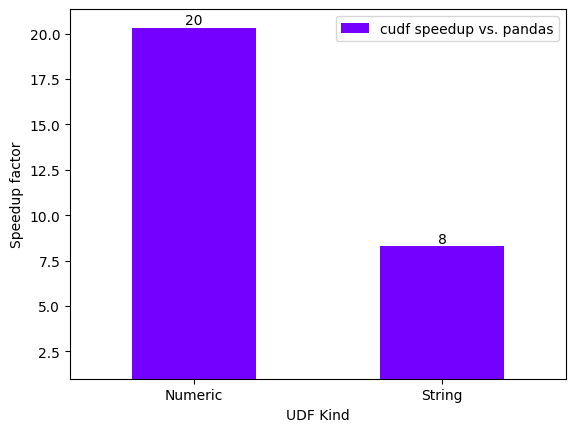

In [29]:
performance_plot(performance_df, xlabel="UDF Kind")

## User-defined function (UDF) performance (without JIT overhead)

In [30]:
timeit_number = 10

In [31]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age,
    gdf_age,
    lambda df: df.apply(age_udf, axis=1),
    number=timeit_number,
)

In [32]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series,
    gd_series,
    lambda s: s.apply(str_isupper_udf),
    number=timeit_number,
)

In [33]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,21377.625003
String,37.422872


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their consequent runs. In this case the speedup is massive because of no JIT overhead present.

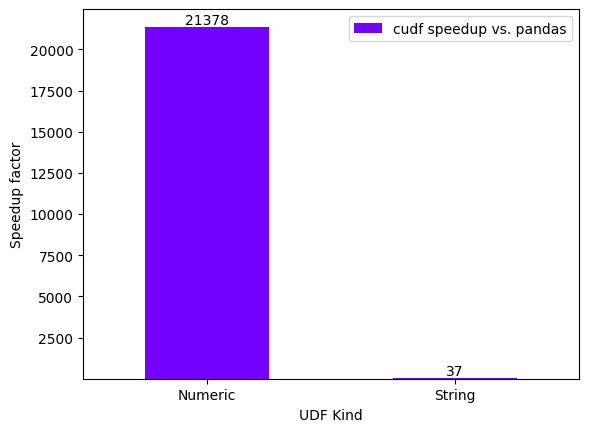

In [34]:
performance_plot(performance_df, xlabel="UDF Kind")

## UDF Performance in GroupBy

In [35]:
num_rows = 100_000_000
timeit_number = 10

In [36]:
pdf = pd.DataFrame()
pdf["key"] = rng.integers(0, 2, num_rows)
pdf["val"] = rng.integers(0, 7, num_rows)


def custom_formula_udf(df):
    df["out"] = df["key"] * df["val"] - 10
    return df


gdf = cudf.from_pandas(pdf)

In [37]:
pandas_udf_groupby, cudf_udf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
    number=timeit_number,
)

/tmp/ipykernel_948063/2864685541.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
/tmp/ipykernel_948063/2864685541.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
/tmp/ipykernel_948063/2864685541.py:4: DeprecationWarning: DataFrameGroupBy.apply operat

In [38]:
performance_df = pd.DataFrame(
    {"cudf speedup vs. pandas": [pandas_udf_groupby / cudf_udf_groupby]},
    index=["Grouped UDF"],
)
performance_df

,cudf speedup vs. pandas
Grouped UDF,88.879055


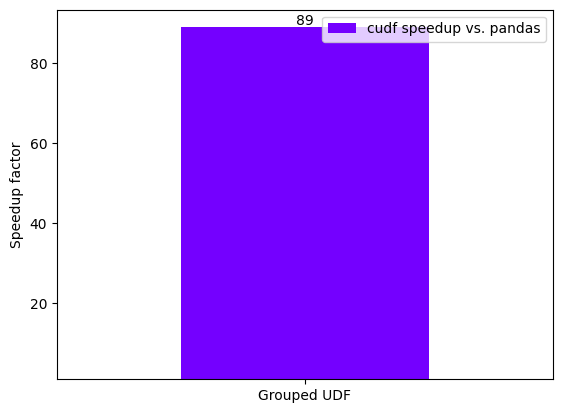

In [39]:
performance_plot(performance_df)

# System Configuration

## CPU Configuration

In [40]:
!lscpu

Architecture:           x86_64
  CPU op-mode(s):       32-bit, 64-bit
  Address sizes:        52 bits physical, 57 bits virtual
  Byte Order:           Little Endian
CPU(s):                 224
  On-line CPU(s) list:  0-223
Vendor ID:              GenuineIntel
  Model name:           Intel(R) Xeon(R) Platinum 8480CL
    CPU family:         6
    Model:              143
    Thread(s) per core: 2
    Core(s) per socket: 56
    Socket(s):          2
    Stepping:           7
    CPU max MHz:        3800.0000
    CPU min MHz:        800.0000
    BogoMIPS:           4000.00
    Flags:              fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca
                         cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht
                         tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art ar
                        ch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc 
                        cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 mon
                   

## GPU Configuration

In [41]:
!nvidia-smi

Wed Mar  6 12:35:15 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA H100 80G...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0   119W / 700W |  44191MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA H100 80G...  On   | 00000000:43:00.0 Off |                    0 |
| N/A   